In [1]:
# Run python sript if enter_parameters is needed.
# Run ipython or notebook with enter_parameters disabled if cell outputs need to be saved.
run_from_ipython = 'get_ipython' in globals()
# Use ipython display when running notebook. Print directly to console when running sript.
display = display if run_from_ipython else print

In [2]:
import os
import json
import numpy as np
import pandas as pd
import xarray as xr
import scipy as sp
import matplotlib.pyplot as plt

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.visualization import plot_spike_counts

from utils import *
from process import *
from analysis import *
from plots import *

if run_from_ipython:
    %matplotlib inline

with open('config.json') as f:
    config = json.load(f)

In [3]:
# Cache directory path, it determines where downloaded data will be stored
manifest_path = os.path.join(config['cache_dir'], "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

# Whether to manually enter parameters for analysis
enter_parameters = config['enter_parameters']
whether_redo = redo_condition(enter_parameters)

## Get session and probe

In [4]:
session_id = config['analysis_object']['session_id']
ecephys_structure_acronym = config['analysis_object']['ecephys_structure_acronym']
session = cache.get_session_data(session_id)

In [5]:
output_dir = config['output_dir']
session_dir = os.path.join(output_dir, f'session_{session_id:d}')
info_file = os.path.join(output_dir, f'session_{session_id:d}_{ecephys_structure_acronym:s}.json')
with open(info_file) as f:
    info = json.load(f)
print(json.dumps(info, indent=4))

probe_id = info['probe_id']
probe_dir = os.path.join(session_dir, f'probe_{probe_id:d}')
parameters_dict = info['parameters']
fig_disp = figure_display_function(config)

{
    "session_id": 721123822,
    "ecephys_structure_acronym": "VISp",
    "probe_id": 760213145,
    "center_channel_id": 850245983,
    "center_unit_channel_id": 850245985,
    "fs": 1249.99999145772,
    "parameters": {
        "spike_bin_width": 0.03,
        "fr_smooth_sigma": 0.02,
        "fr_normalize_quantile": 0.2,
        "fr_normalization_scale": "range",
        "soft_normalize_cut": 26.666666666666668,
        "stimulus_rise_duration": [
            -0.05,
            0.33
        ],
        "display_PCs": [
            1,
            2
        ],
        "number_top_PCs": 3,
        "select_temporal_frequency_index": [
            0,
            1,
            2,
            3
        ],
        "stimulus_stable_duration": [
            0.3,
            2.001770000000306
        ],
        "number_orientation_clusters": 3,
        "two_step_clustering": true,
        "filter_extend_time": 0.2,
        "filter_freq_band": [
            20.0,
            40.0
        ],
 

## Load LFP channels

In [6]:
filepath = os.path.join(probe_dir, f'{ecephys_structure_acronym:s}_lfp_channel_groups.nc')
with xr.open_dataset(filepath) as f:
    lfp_array = f.load()
lfp_array = lfp_array.assign_attrs(fs=info['fs']).rename(group_id='channel')
display(lfp_array)

<xarray.Dataset>
Dimensions:  (time: 12263286, channel: 8)
Coordinates:
  * time     (time) float64 0.5328 0.5336 0.5344 ... 9.811e+03 9.811e+03
  * channel  (channel) int32 0 1 2 3 4 5 6 7
Data variables:
    LFP      (channel, time) float32 1.3e-06 1.82e-06 ... -1.55e-05 -8.287e-06
Attributes:
    fs:       1249.99999145772

## Load selected units in area of interest

In [7]:
units_file = os.path.join(output_dir, f'session_{session_id:d}_{ecephys_structure_acronym:s}_units.csv')
sel_units = pd.read_csv(units_file, index_col='unit_id')
sel_units_id = sel_units.index
print(f'Number of units in {ecephys_structure_acronym:s}: {len(sel_units):d}')

Number of units in VISp: 41


### Save data settings

In [8]:
filepath_prefix = lambda stimulus_name: os.path.join(probe_dir, f'{ecephys_structure_acronym:s}_{stimulus_name:s}')

## Analyze spikes

### Get natural movies spike counts

In [9]:
stimulus_names = ['natural_movie_one', 'natural_movie_three']

In [10]:
units_spk_counts = {}
units_frs = {}

bin_width = []
for stim in stimulus_names:
    presentations, _, _, trial_duration = align_movie(
        session.stimulus_presentations, stimulus_name=stim)
    # duration of each frame
    bin_width.append(trial_duration / (presentations['stimulus_condition_id'].unique().size))
bin_width = np.mean(bin_width)

for stim in stimulus_names:
    spk_file = filepath_prefix(stim) + '_unit_spike_counts.nc'
    if os.path.isfile(spk_file):
        spk_counts = xr.load_dataset(spk_file)
    else:
        presentations, presentations_ids, presentations_times, trial_duration = align_movie(
            session.stimulus_presentations, stimulus_name=stim)
        
        spk_counts = get_units_spike_counts(session, presentations_ids, sel_units_id,
                                            bin_width=bin_width, window=(0., trial_duration))
        spk_counts = spk_counts.to_dataset(name='spike_counts').assign_attrs(
            trial_duration=trial_duration, bin_width=bin_width)
        spk_counts.to_netcdf(spk_file)
    # spike counts to firing rate
    spk_counts = spk_counts.rename(spike_counts='spike_rate')
    spk_counts = spk_counts.assign(spike_rate=spk_counts.spike_rate / spk_counts.bin_width)
    units_spk_counts[stim] = spk_counts
    # average over trials
    fr = spk_counts.copy()
    units_frs[stim] = fr.assign(spike_rate=fr.spike_rate.mean(dim='stimulus_presentation_id'))

In [11]:
average_trials = True

units_fr = stimuli_data_to_samples((units_frs if average_trials else units_spk_counts).values(),
                                   average_trials=average_trials)

units_fr = units_fr.to_dataset(name='spike_rate').assign(
    units_fr_mean = units_fr.mean(dim='sample'),
    units_fr_std = units_fr.std(dim='sample'),
    units_fr_min = units_fr.min(dim='sample'),
    units_fr_max = units_fr.max(dim='sample'),
)
units_fr = units_fr.assign(units_fr_range=units_fr.units_fr_max - units_fr.units_fr_min)
fr_stats = {var: units_fr[var] for var in units_fr.var() if var != 'spike_rate'}

### Check overall firing rate

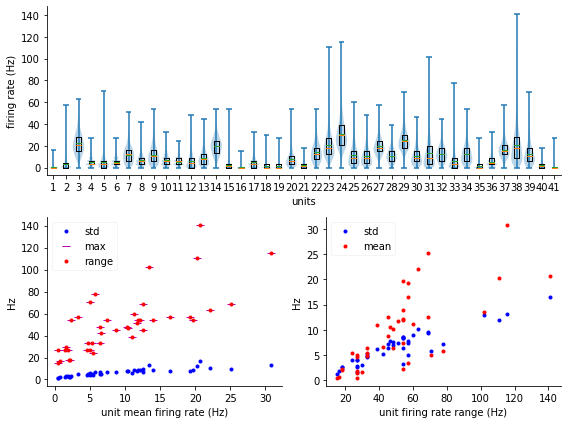

In [12]:
spike_rate = units_fr.spike_rate
plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
plt.violinplot(spike_rate.values, widths=.9)
plt.boxplot(spike_rate.values, widths=0.4, whis=(0, 100),
            showmeans=True, meanline=True, showfliers=False, showcaps=False,
            meanprops={'linestyle': '-'}, whiskerprops={'color':'none'})
plt.xlabel('units')
plt.ylabel('firing rate (Hz)')

plt.subplot(2, 2, 3)
plt.plot(units_fr.units_fr_mean, units_fr.units_fr_std, 'b.', label='std')
plt.plot(units_fr.units_fr_mean, units_fr.units_fr_max, 'm.', marker='_', markersize=8, label='max')
plt.plot(units_fr.units_fr_mean, units_fr.units_fr_range, 'r.', label='range')
plt.xlabel('unit mean firing rate (Hz)')
plt.ylabel('Hz')
plt.legend(loc='upper left', framealpha=0.2)
plt.subplot(2, 2, 4)
plt.plot(units_fr.units_fr_range, units_fr.units_fr_std, 'b.', label='std')
plt.plot(units_fr.units_fr_range, units_fr.units_fr_mean, 'r.', label='mean')
plt.xlabel('unit firing rate range (Hz)')
plt.ylabel('Hz')
plt.legend(loc='upper left', framealpha=0.2)

plt.tight_layout()
plt.show()

### Preprocess units firing rate

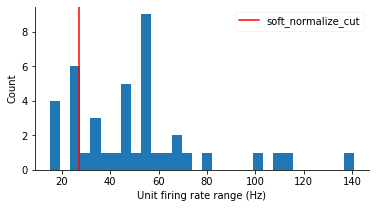

In [13]:
sigma = 0.02 # sec
quantile = 0.2
normalization_scale = 'range' # 'range', 'std', 'mean'

norm_scale = getattr(units_fr, 'units_fr_' + normalization_scale)
soft_normalize_cut = np.quantile(norm_scale, quantile)
plt.figure(figsize=(6, 3))
plt.hist(norm_scale, bins=30)
plt.axvline(soft_normalize_cut, color='r', label='soft_normalize_cut')
plt.xlabel(f'Unit firing rate {normalization_scale:s} (Hz)')
plt.ylabel('Count')
plt.legend(loc='upper right', framealpha=0.2)
plt.show()

In [14]:
for stim in stimulus_names:
    units_spk_counts[stim] = preprocess_firing_rate(units_spk_counts[stim].assign(fr_stats), sigma,
        soft_normalize_cut=soft_normalize_cut, normalization_scale=norm_scale)
    units_frs[stim] = preprocess_firing_rate(units_frs[stim].assign(fr_stats), sigma,
        soft_normalize_cut=soft_normalize_cut, normalization_scale=norm_scale)

### Get natural movies LFP and power

In [15]:
channel_id = info['center_unit_channel_id']
channel_group_map = pd.read_csv(filepath.replace('.nc', '.csv'), index_col='id')
unit_channel = pd.Series(channel_group_map.loc[sel_units['peak_channel_id'], 'group_id'].values,
                         index=sel_units_id, name='channel_group_id')
# group_id = channel_group_map.loc[channel_id, 'group_id']
group_id = unit_channel.mode().item()

print(f"Channel group: {group_id:d}")

Channel group: 4


In [16]:
extend_time = 0.5

freq_band = dict(beta=[20., 40.], gamma=[40., 70.])
waves = list(freq_band)
n_waves = len(waves)
colors = {'beta': 'b', 'gamma': 'r'}

filt_sigma = int(bin_width * lfp_array.fs)

In [17]:
lfp_filts = {}
for stim in stimulus_names:
    lfp_filt_file = filepath_prefix(stim) + '_lfp_filt_power.nc'
    if os.path.isfile(lfp_filt_file):
        lfp_filt = xr.load_dataset(lfp_filt_file)
    else:
        _, presentations_ids, presentations_times, trial_duration = align_movie(
            session.stimulus_presentations, stimulus_name=stim)
        aligned_lfp = align_trials(lfp_array, presentations_ids, presentations_times, window=(0. - extend_time, trial_duration + extend_time))
        aligned_lfp = aligned_lfp.sel(channel=group_id).assign_attrs(extend_time=extend_time)
        lfp_filt = {}
        for w in waves:
            filt_ds = bandpass_lfp(aligned_lfp, freq_band[w], output='sos')
            # calculate power from amplitude (convert to uV)
            lfp_power = (filt_ds.amplitude * 1e6) ** 2 / 2
            lfp_power_total = 1e12 * gauss_filt_da(aligned_lfp.LFP ** 2, filt_sigma, dim='time_from_presentation_onset')
            lfp_power_normalized = lfp_power / lfp_power_total  # normalize by sqrt of power
            filt_ds = filt_ds.assign(
                lfp_power=lfp_power,
                lfp_power_total=lfp_power_total,
                lfp_power_normalized=lfp_power_normalized,
            )
            lfp_filt[w] = filt_ds
        lfp_filt = xr.concat(lfp_filt.values(), dim=pd.Index(waves, name='wave'))
        # downsample to spike time histogram sampling rate
        t = units_spk_counts[stim].time_relative_to_stimulus_onset.values
        wins = t[:, None] + units_spk_counts[stim].bin_width / 2 * np.array([-1, 1])
        ds_wins = []
        for win in wins:
            ds_wins.append(lfp_filt.sel(time_from_presentation_onset=slice(*win)).mean(dim='time_from_presentation_onset'))
        lfp_filt = xr.concat(ds_wins, dim=pd.Index(t, name='time_from_presentation_onset')).assign_attrs(**lfp_filt.attrs)
        lfp_filt.to_netcdf(lfp_filt_file)
    lfp_filts[stim] = lfp_filt

natural_movie_one
lfp_power


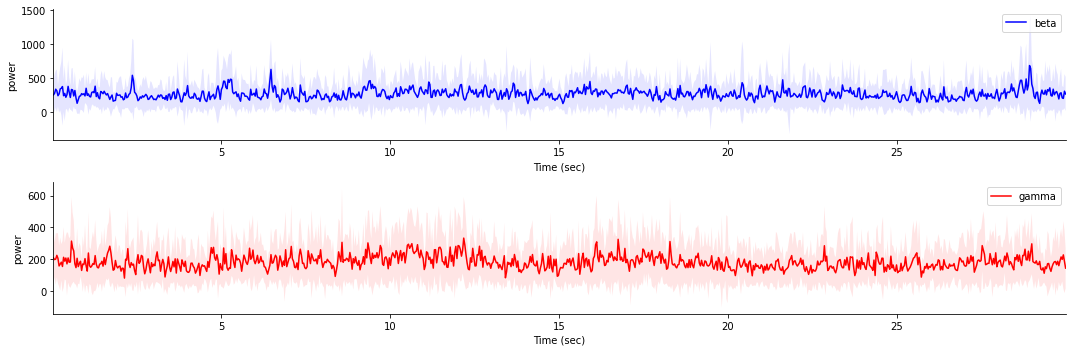

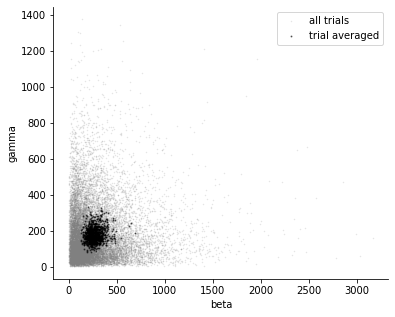

lfp_power_normalized


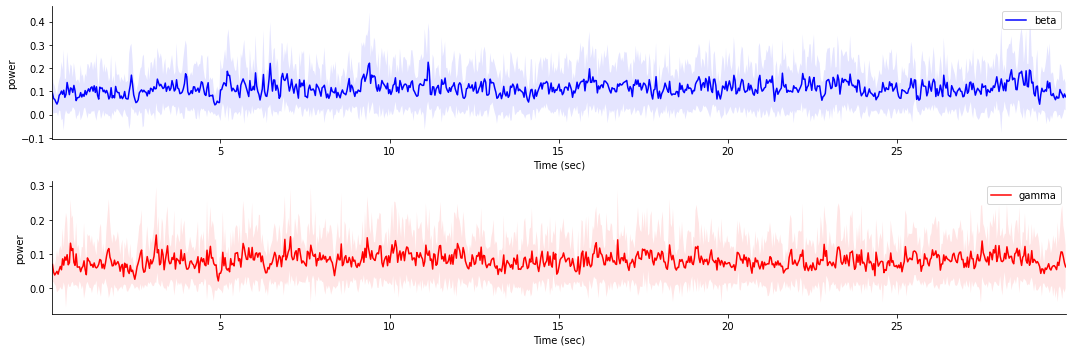

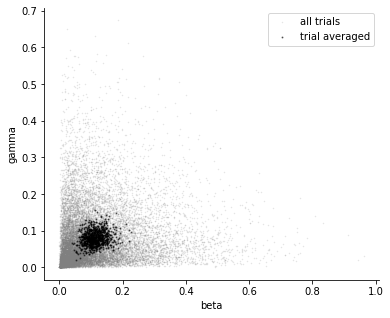

natural_movie_three
lfp_power


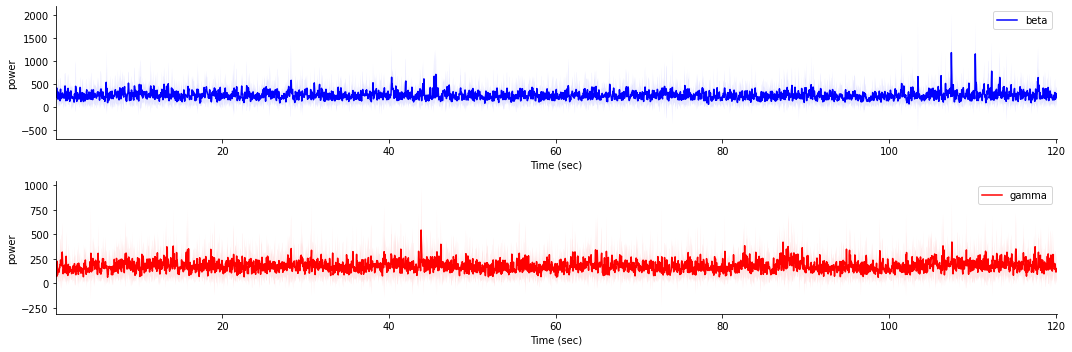

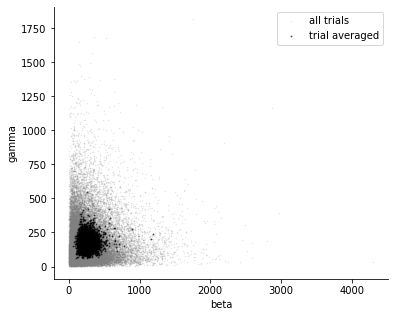

lfp_power_normalized


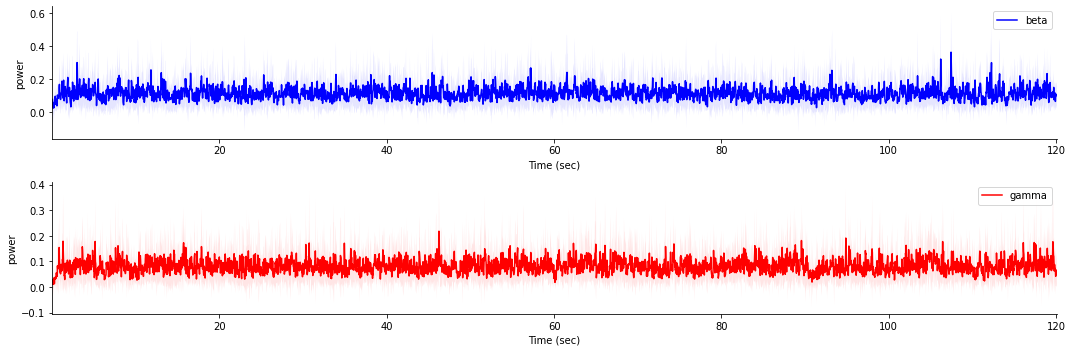

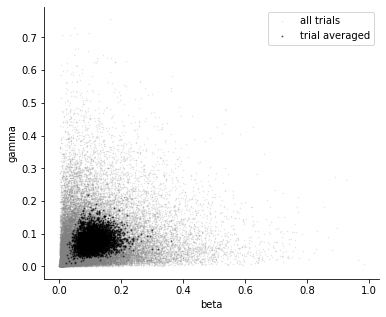

In [18]:
for stim, lfp_filt in lfp_filts.items():
    print(stim)
    t = lfp_filt.time_from_presentation_onset
    for var in ['lfp_power', 'lfp_power_normalized']:
        print(var)
        power = lfp_filt[var]
        pow_mean = []
        _, axs = plt.subplots(2, 1, figsize=(15, 5))
        for ax, w in zip(axs, waves):
            x = power.sel(wave=w)
            x_mean = x.mean(dim='presentation_id')
            pow_mean.append(x_mean.values.ravel())
            x_std = x.std(dim='presentation_id')
            ax.plot(t, x_mean, color=colors[w], label=w)
            ax.fill_between(t, x_mean - x_std, x_mean + x_std, facecolor=colors[w], edgecolor='none', alpha=0.1)
            ax.set_xlim(t[0], t[-1])
            ax.set_xlabel('Time (sec)')
            ax.set_ylabel('power')
            ax.legend(loc='upper right')
        plt.tight_layout()

        plt.figure(figsize=(6, 5))
        pow = [power.sel(wave=w).values.ravel() for w in waves[:2]]
        plt.plot(*pow, '.', color='gray', markersize=1, alpha=0.2, label='all trials')
        plt.plot(*pow_mean, '.', color='k', markersize=2, alpha=0.5, label='trial averaged')
        plt.xlabel(waves[0])
        plt.ylabel(waves[1])
        plt.legend(loc='upper right')
        plt.show()

## PCA analysis

Explained variance % of top 10 components: 
15.98, 10.86, 7.98, 5.20, 4.98, 4.25, 3.87, 3.24, 3.07, 2.72


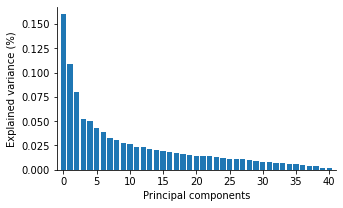

In [19]:
from sklearn.decomposition import PCA

average_trials = True
units_vec = stimuli_data_to_samples((units_frs if average_trials else units_spk_counts).values(),
                                   average_trials=average_trials, var='normalized')

n_units = units_vec.unit_id.size
n_components = n_units
pca = PCA(n_components=n_components)
pca.fit(units_vec)

print('Explained variance % of top 10 components: \n' + 
      ', '.join('%.2f' % (100 * x) for x in pca.explained_variance_ratio_[:10]))
plt.figure(figsize=(5, 3))
plt.bar(np.arange(n_components), pca.explained_variance_ratio_)
plt.xlim(-1, n_components)
plt.xlabel('Principal components')
plt.ylabel('Explained variance (%)')
plt.show()

In [20]:
pop_vecs = {}
for stim, spk_counts in units_spk_counts.items():
    pop_vec = stack_time_samples(spk_counts.normalized, average_trials=False)
    pop_vec = pop_vec.copy(data=pca.transform(pop_vec)).rename(unit_id='PC').unstack('sample')
    pop_vec.coords['PC'] = range(n_components)
    pop_vecs[stim] = pop_vec

### Population trajectories

#### Choose LFP waves power metric

In [95]:
n_main_pc = 3  # number of main PCs (top n_main_pc)
PC_main = list(range(n_main_pc))
PC_disp = list(range(2))  # first 2 PCs for display
cmap = 'jet'

spk_sample_dims = ('stimulus_presentation_id', 'time_relative_to_stimulus_onset')
lfp_sample_dims = ('presentation_id', 'time_from_presentation_onset')
pc_dims = ('PC', 'sample')

power_metric = 'lfp power'

if power_metric == 'lfp power':
    # filtered power
    waves_power = {stim: power.lfp_power for stim, power in lfp_filts.items()}
elif power_metric == 'normalized lfp power':
    # filtered power normalized by total power
    waves_power = {stim: power.lfp_power_normalized for stim, power in lfp_filts.items()}

#### Calculate velocity

In [96]:
pop_vels = {}  # velocity
pop_speeds = {}  # speed along main PCs
pop_angs = {}  # angle changed along main PCs
for stim, pop_vec in pop_vecs.items():
    pop_vec0 = pop_vec.isel(time_relative_to_stimulus_onset=slice(1, None))
    pop_vec1 = pop_vec.isel(time_relative_to_stimulus_onset=slice(None, -1))
    pop_vel = pop_vec0.copy(data=pop_vec0.values - pop_vec1.values)
    pop_vels[stim] = pop_vel
    # consider only main PCs
    pop_speeds[stim] = speed = (pop_vel.sel(PC=PC_main) ** 2).sum(dim='PC') ** 0.5
    pop_vec_len = (pop_vec.sel(PC=PC_main) ** 2).sum(dim='PC') ** 0.5
    pop_vec0_len = pop_vec_len.isel(time_relative_to_stimulus_onset=slice(1, None))
    pop_vec1_len = pop_vec_len.isel(time_relative_to_stimulus_onset=slice(None, -1))
    pc_axis = pop_vec.dims.index('PC')
    dot = np.sum(pop_vec0.sel(PC=PC_main).values * pop_vec1.sel(PC=PC_main).values, axis=pc_axis)
    pop_angs[stim] = speed.copy(data=np.degrees(np.arccos(dot / (pop_vec0_len.values * pop_vec1_len.values))))

#### Calculate total mean firing rate

In [97]:
mean_tot_frs = {}  # mean total normalized firing rate of all units
for stim, spk_counts in units_spk_counts.items():
    mean_tot_frs[stim] = spk_counts.normalized.isel(time_relative_to_stimulus_onset=slice(1, None)).mean(dim='unit_id')

#### Plots

Average trajectory


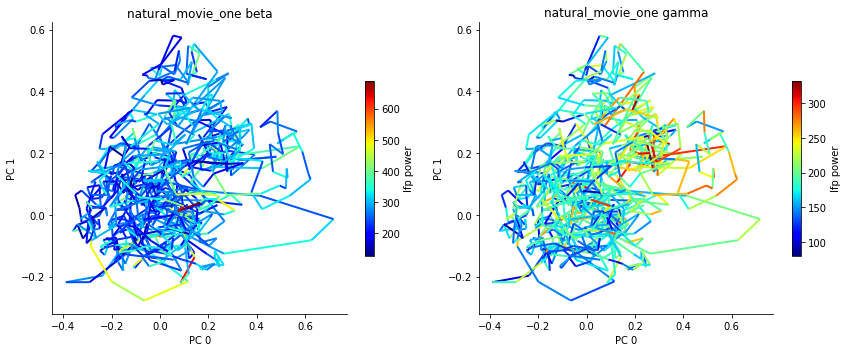

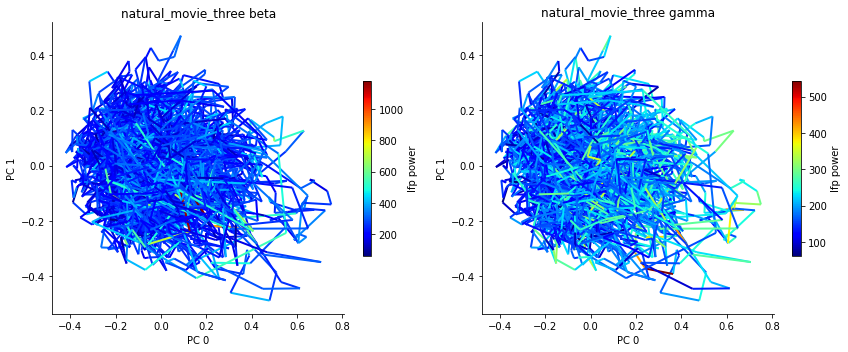

In [98]:
figsize = (6, 5)

print('Average trajectory')
for stim, pop_vec in pop_vecs.items():
    pop_vec_avg = pop_vec.sel(PC=PC_disp).transpose('PC', *spk_sample_dims).mean(dim='stimulus_presentation_id')
    power = waves_power[stim].mean(dim='presentation_id')
    _, axs = plt.subplots(1, n_waves, figsize=(n_waves * figsize[0], figsize[1]))
    for ax, w in zip(axs, waves):
        line = plot_multicolor_line(*pop_vec_avg, c=power.sel(wave=w)[1:], ax=ax, cmap=cmap)
        plt.colorbar(mappable=line, ax=ax, label=power_metric, shrink=0.6)
        ax.autoscale_view()
        ax.set_xlabel(f'PC {PC_disp[0]:d}')
        ax.set_ylabel(f'PC {PC_disp[1]:d}')
        ax.set_title(f'{stim:s} {w:s}')
    plt.tight_layout()
plt.show()

All trials


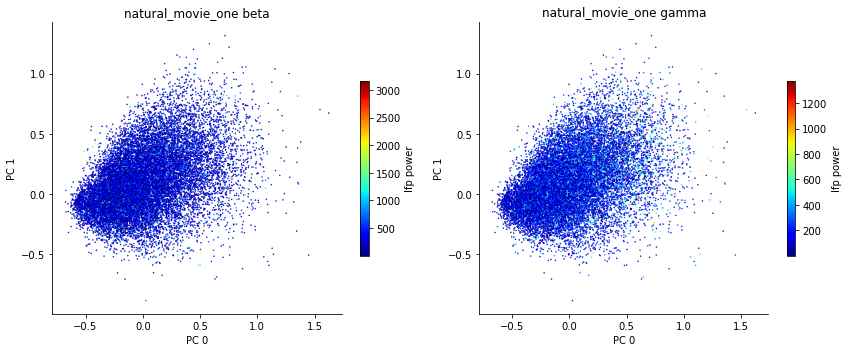

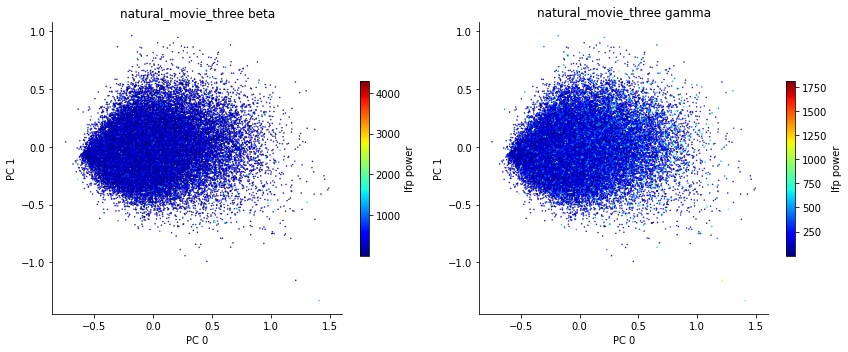

In [99]:
print('All trials')
for stim, pop_vec in pop_vecs.items():
    pop_vec = stack_time_samples(pop_vec.sel(PC=PC_disp), average_trials=False).transpose(*pc_dims)
    power = stack_time_samples(waves_power[stim], sample_dims=lfp_sample_dims, average_trials=False)
    _, axs = plt.subplots(1, n_waves, figsize=(n_waves * figsize[0], figsize[1]))
    for ax, w in zip(axs, waves):
        sc = ax.scatter(*pop_vec, c=power.sel(wave=w), s=1, marker='.', cmap=cmap)
        plt.colorbar(mappable=sc, ax=ax, label=power_metric, shrink=0.6)
        ax.autoscale_view()
        ax.set_xlabel(f'PC {PC_disp[0]:d}')
        ax.set_ylabel(f'PC {PC_disp[1]:d}')
        ax.set_title(f'{stim:s} {w:s}')
    plt.tight_layout()
plt.show()

All trials velocity


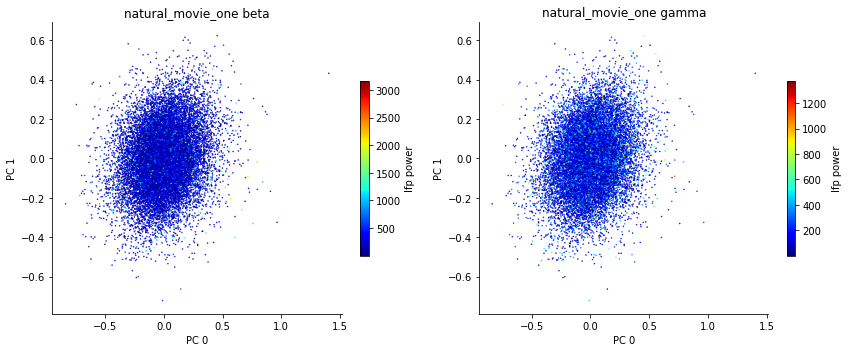

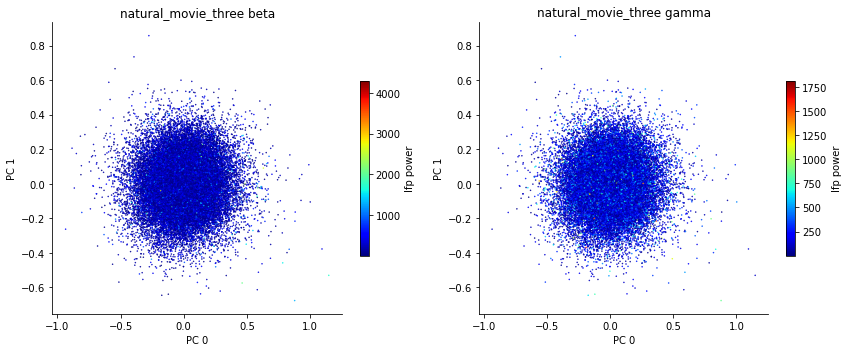

In [100]:
print('All trials velocity')
for stim, pop_vel in pop_vels.items():
    pop_vel = stack_time_samples(pop_vel.sel(PC=PC_disp), average_trials=False).transpose(*pc_dims)
    power = stack_time_samples(waves_power[stim].isel(time_from_presentation_onset=slice(1, None)),
                               sample_dims=lfp_sample_dims, average_trials=False)
    _, axs = plt.subplots(1, n_waves, figsize=(n_waves * figsize[0], figsize[1]))
    for ax, w in zip(axs, waves):
        sc = ax.scatter(*pop_vel, c=power.sel(wave=w), s=1, marker='.', cmap=cmap)
        plt.colorbar(mappable=sc, ax=ax, label=power_metric, shrink=0.6)
        ax.autoscale_view()
        ax.set_xlabel(f'PC {PC_disp[0]:d}')
        ax.set_ylabel(f'PC {PC_disp[1]:d}')
        ax.set_title(f'{stim:s} {w:s}')
    plt.tight_layout()
plt.show()

All trials mean firing rate


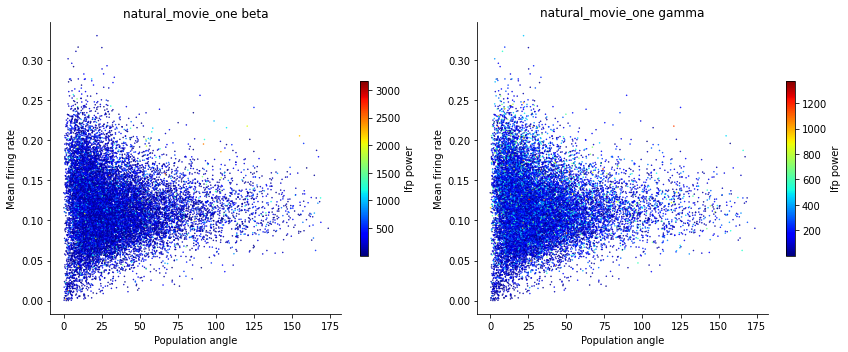

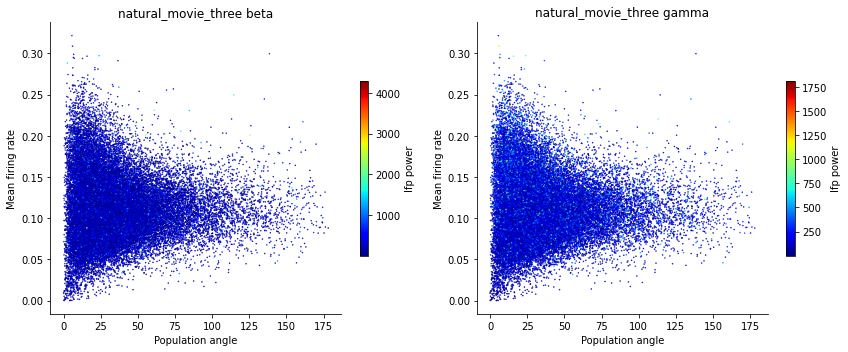

In [101]:
print('All trials mean firing rate')
for stim in stimulus_names:
    pop_ang = stack_time_samples(pop_angs[stim], average_trials=False, sample_dims=spk_sample_dims)
    mean_tot_fr = stack_time_samples(mean_tot_frs[stim], average_trials=False, sample_dims=spk_sample_dims)
    power = stack_time_samples(waves_power[stim].isel(time_from_presentation_onset=slice(1, None)),
                               sample_dims=lfp_sample_dims, average_trials=False)
    _, axs = plt.subplots(1, n_waves, figsize=(n_waves * figsize[0], figsize[1]))
    for ax, w in zip(axs, waves):
        sc = ax.scatter(pop_ang, mean_tot_fr, c=power.sel(wave=w), s=1, marker='.', cmap=cmap)
        plt.colorbar(mappable=sc, ax=ax, label=power_metric, shrink=0.6)
        ax.autoscale_view()
        ax.set_xlabel('Population angle')
        ax.set_ylabel('Mean firing rate')
        ax.set_title(f'{stim:s} {w:s}')
    plt.tight_layout()
plt.show()